# Drug Discovery using the ChEMBL Webresource Client

This notebook will create **two csv files** based on the TARGET_ID - the integer portion of *molecule_chembl_id*

* preprocessed data with added columns for Lapinski descriptors, $pIC_{50}$ values, and a binary class variable ('ACTIVE', 'INACTIVE') indicating whether or not each molecule is reactive with the target.

* the chemical fingerprint for each molecule in the dataset (the function to create this file probably needs to be optimized using the *padeldescriptor* import because it has a very long runtime)

Dependencies include the ChEMBL Webresource Client, RDKit, and PaDELPy

A note on modeling: $R^2$ is the percent of the variance in [potency](https://en.wikipedia.org/wiki/Potency_(pharmacology)) (as measured by $pIC_{50}$) is explained by the chemical fingerprint of the molecule.

## Contents

1.   [Acquire & prepare molecular data](#Acquire)
2.   [Explore molecular descriptors](#Explore)
3.   [Model](#Model)



In [5]:
import pandas as pd
from src.prepare import preprocess_bioactivity_data

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='Acquire'></a>
## Acquire & prepare molecular data

In [6]:
TARGET_ID = 3927 #SARS coronavirus 3C-like proteinase
preprocess_bioactivity_data(TARGET_ID, tests=False, fingerprints=True)


Query results retrieved for 3927...
Saving 119 molecules.

Computing fingerprints (takes several minutes if molecules > 1000)...
Success!



In [7]:
bioactivity_df = pd.read_csv(f'{TARGET_ID}_bioactivity_preprocessed.csv')
bioactivity_df.tail()

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
114,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,10600.0,INACTIVE,338.359,3.40102,0.0,5.0,4.97
115,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,10100.0,INACTIVE,296.366,3.44330,0.0,3.0,5.00
116,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,11500.0,INACTIVE,276.291,4.09564,0.0,3.0,4.94
117,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,10700.0,INACTIVE,278.307,3.29102,0.0,3.0,4.97
118,CHEMBL45830,CC(C)C1=Cc2ccc3c(c2C(=O)C1=O)CCCC3(C)C,78900.0,INACTIVE,282.383,4.10530,0.0,2.0,4.10


In [8]:
fingerprints= pd.read_csv(f'{TARGET_ID}_pubchem_fp.csv')
fingerprints.tail()

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
114,CHEMBL187460,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
115,CHEMBL2146517,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116,CHEMBL227075,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
117,CHEMBL363535,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
118,CHEMBL45830,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


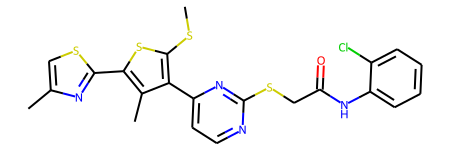

In [31]:
from rdkit import Chem
Chem.MolFromSmiles(bioactivity_df.canonical_smiles[36]) #an example molecule

<a id='Explore'></a>
## Explore molecular descriptors

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (5,5)
plt.style.use('fivethirtyeight')

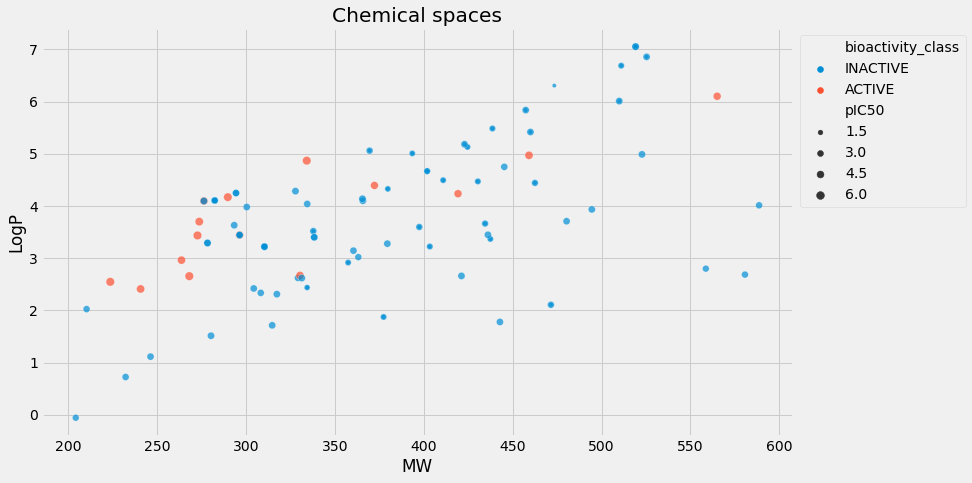

In [32]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x='MW', y='LogP', data=bioactivity_df, hue='bioactivity_class', size='pIC50', alpha=.7)
plt.legend(bbox_to_anchor=(1,1))
plt.title('Chemical spaces')
plt.show()

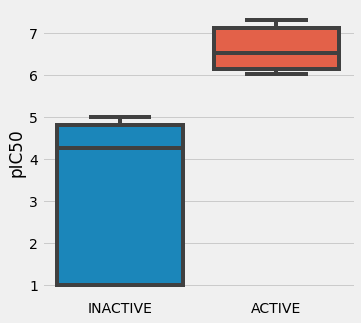

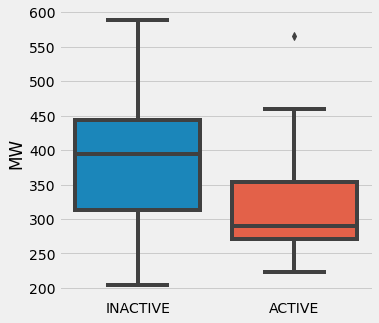

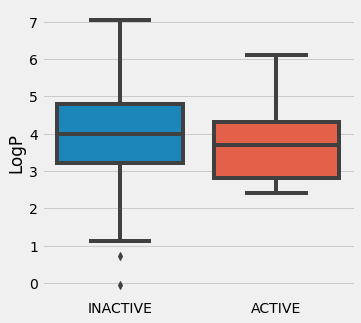

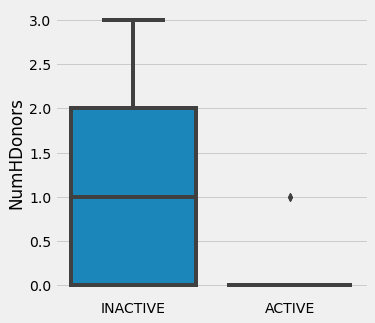

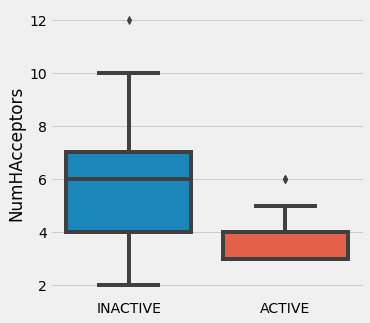

In [36]:
for column in ['pIC50', 'MW', 'LogP', 'NumHDonors', 'NumHAcceptors']:
    sns.boxplot(x='bioactivity_class', y=column, data=bioactivity_df)
    plt.xlabel('')
    plt.show()

<a id='Model'></a>
## Model

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from src.prepare import preprocess_bioactivity_data

In [39]:
y = bioactivity_df['pIC50'] #response variable
y.describe()

count    119.000000
mean       3.900336
std        1.817523
min        1.000000
25%        3.350000
50%        4.410000
75%        4.885000
max        7.300000
Name: pIC50, dtype: float64

In [46]:
selector = VarianceThreshold(.1)
X = selector.fit_transform(fingerprints.iloc[:,1:])

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=36)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((95, 256), (95,), (24, 256), (24,))

We've already dropped features with low variance (under 0.1) thereby reducing the fingerprint from 881 to 100-200 features. Now try to maximize the cross-validation score.


In [59]:
rfr = RandomForestRegressor(n_estimators=100, ccp_alpha=.01, random_state=36)
cv_scores = cross_val_score(rfr, X_train, y_train, cv=5)
print("Scores:", cv_scores)
print("Maximize the average:", round(cv_scores.mean(),3))

Scores: [0.18980322 0.34937586 0.62812826 0.11532169 0.3430654 ]
Maximize the average: 0.325


In [60]:
#Baseline
median = y_train.median()
dr = DummyRegressor(strategy='median').fit(X_train, y_train)
#Evaluation
print("Always predict", median, "\n R^2:", round(dr.score(X_test, y_test),3))

Always predict 4.4 
 R^2: -0.107


In [61]:
#Best model evaluation
rfr.fit(X_train, y_train)
print("Best model R^2:", round(rfr.score(X_test, y_test),3))

Best model R^2: 0.0


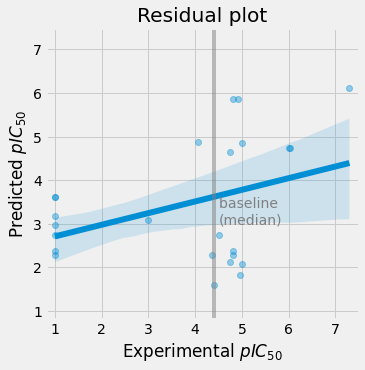

In [62]:
rf_preds = rfr.predict(X_test)

ax = sns.regplot(x=y_test, y=rf_preds, scatter_kws={'alpha':.4})
ax.axvline(y_train.median(), color='gray', alpha=.5)
ax.text(median+.1, 3, 'baseline \n(median)', color='gray')
ax.set_xlabel('Experimental $pIC_{50}$')
ax.set_ylabel('Predicted $pIC_{50}$')
ax.set_title('Residual plot')
pIC50_range = (y_test.min()-.2, y_test.max()+.2)
ax.set_xlim(pIC50_range)
ax.set_ylim(pIC50_range)
plt.show()